In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [3]:
df = pd.read_csv('data/cleaned_all_transactions.csv').iloc[:, 1:]

## **Hypothesis Testing**

As we saw in the cleaning/eda section of the report, the reps from the state of Michigan have a 77% of trades that result in the ```cap_gains_over_200_usd``` column have a True value. 

Is this just by chance, or are the representatives from the *The Great Lakes State* just that damn good?

In [4]:
df = df[['state', 'cap_gains_over_200_usd']]
df.head(5)

,state,cap_gains_over_200_usd
0,NC,False
1,NC,False
2,NC,False
3,NC,False
4,CA,False


Let's look at the data once again.

In [32]:
(
    df.groupby('state').mean()
    .sort_values(by='cap_gains_over_200_usd', ascending=False).head(5)
)


,cap_gains_over_200_usd
state,
MI,0.772871
SC,0.379310
NY,0.280702
ID,0.222222
LA,0.222222


##### There's an easy solution to this problem - **Permutation Testing!**

We're choosing permutation testing over hypothesis testing because we are given *two* observed samples (versus the only *one* that hypothesis testing works on), and we need to see if they are they fundamentally different, or could they have been generated by the same process? 


In [6]:
df.sample(frac=1).head(3)

,state,cap_gains_over_200_usd
13840,CA,False
11123,FL,False
12934,FL,True


We can shuffle the ```cap_gains_over_200_usd``` column to simulate randomness.

In [7]:
shuffled_gains = (
    df['cap_gains_over_200_usd']
    .sample(frac=1)
    # we need to reset_index w/ drop=True otherwise the old index values will exist
    .reset_index(drop=True)
)
shuffled_gains.head(3)

0    False
1    False
2    False
Name: cap_gains_over_200_usd, dtype: bool

In [8]:
og_and_shuffled = (
    df.assign(**{'shuffled_cap_gains_over_200_usd': shuffled_gains})
)
og_and_shuffled.head(3)

,state,cap_gains_over_200_usd,shuffled_cap_gains_over_200_usd
0,NC,False,False
1,NC,False,False
2,NC,False,False


Now that we've done the shuffling once, let's recreate the pivot table we saw before, but this time with the added ```shuffled_cap_gains_over_200_usd``` column. 

Clearly Michigan has a pretty big difference between its original 
```cap_gains_over_200_usd``` column and the shuffled version.

In [34]:
table = (
    og_and_shuffled.pivot_table(index = 'state')
    .sort_values(by = 'cap_gains_over_200_usd', ascending=False)
)
table.head(3)

,cap_gains_over_200_usd,shuffled_cap_gains_over_200_usd
state,,
MI,0.772871,0.066246
SC,0.379310,0.068966
NY,0.280702,0.061404


**Here's a graph** representing the same thing as the table above, but for all states.

Clearly in the shuffled version, there doesn't seem to be 1 state that has a disproportionately high or low level of capital gains. That is very much not the case with the original data (right side), with the top 5 states having a disproportionately high level of capital gains.

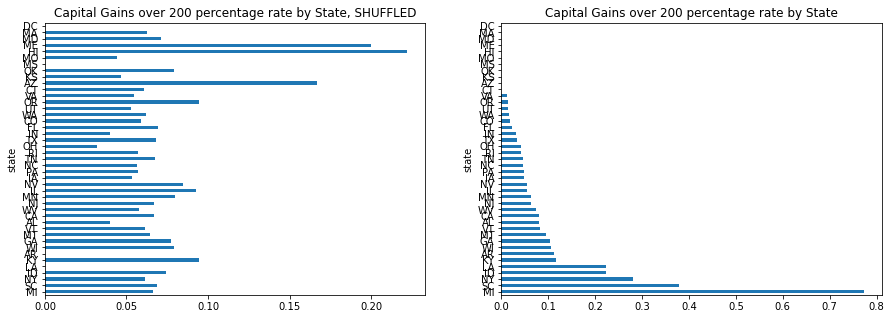

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

title = 'Capital Gains over 200 percentage rate by State, SHUFFLED'
table['shuffled_cap_gains_over_200_usd'].plot(kind='barh', title=title, ax=axes[0]);

title = 'Capital Gains over 200 percentage rate by State'
table['cap_gains_over_200_usd'].plot(kind='barh', title=title, ax=axes[1]);

Just for fun, let's draw the CDFs of both groups, and calculate the KS statistic and the corresponding p-value.

KstestResult(statistic=0.37209302325581395, pvalue=0.004834114654932304)

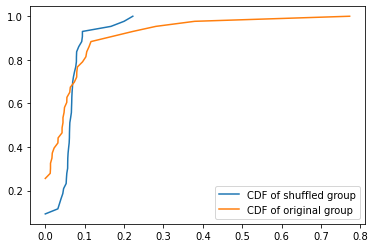

In [36]:
# separate groups into 2 different series
gpA = table['shuffled_cap_gains_over_200_usd']
gpB = table['cap_gains_over_200_usd']

# plot the 2 groups' CDF's by first normaling the data, then taking cumulative sum
plt.plot(gpA.value_counts(normalize=True).sort_index().cumsum(), label='CDF of shuffled group')
plt.plot(gpB.value_counts(normalize=True).sort_index().cumsum(), label='CDF of original group')
plt.legend();

The KS stat of 0.37 does not tell us much, but let's look at the p-value, of **0.0048!**

This is lower than even a 1% significance level, and tells us that the **difference between the 2 groups is highly significant; it is not just due by chance!**

In [37]:
ks_2samp(gpA, gpB)

KstestResult(statistic=0.37209302325581395, pvalue=0.004834114654932304)

Now let's go on to the real permutation testing. Here's the steps we will follow:

1. Shuffle the `cap_gains_over_200_usd` column
2. Put them in a DataFrame.
3. compute stat? (WHAT IS OUR STAT LMAO???????????)
4. Store the result.

In [38]:
# og_and_shuffled.groupby('state').mean().sort_values(by='cap_gains_over_200_usd', ascending=False).loc['MI']